In [1]:
import uproot
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as opt
import sys
import h5py
from sklearn.metrics import mean_squared_error

In [2]:
# sys.path.append('/project/rpp-blairt2k/jgao/WatChMaL')
sys.path.append('../WatChMaL')
import analysis.event_utils as ev

In [3]:
# list of particle names to use in filename
# particle_names = ['gamma', 'e-', 'mu-', 'pi0'] # note that the order corresponds to labels 0, 1, 2, 3
particle_names = ['e-', 'mu-']
# particle_names = ['e-']

# Preparing data

## Get true particle data from h5 file

In [4]:
# get indices of test events
# idxs_path = '/project/rpp-blairt2k/machine_learning/data/HKHybrid/numpy/HKHybrid_e-gamma_E0to1000MeV_unif-pos-R3240-y3287cm_4pi-dir_idxs_w_mPMT.npz'
idxs_path = '/project/rpp-blairt2k/machine_learning/data/HKHybrid/numpy/e-mu-_w_mpmts_idxs.npz'
idxs = np.load(idxs_path, allow_pickle=True)
test_idxs = idxs['test_idxs']

In [5]:
# open h5 file and get data for test events
# data_path = "/project/rpp-blairt2k/machine_learning/data/HKHybrid/numpy/HKHybrid_e-gamma_E0to1000MeV_unif-pos-R3240-y3287cm_4pi-dir_6Mevts_w_mPMT.hdf5"
data_path = "/project/rpp-blairt2k/machine_learning/data/HKHybrid/numpy/e-mu-pi0.hdf5"
h5_file = h5py.File(data_path, "r")
h5_angles     = np.array(h5_file['angles'])[test_idxs].squeeze()
h5_energies   = np.array(h5_file['energies'])[test_idxs].squeeze()
h5_positions  = np.array(h5_file['positions'])[test_idxs].squeeze()
h5_labels     = np.array(h5_file['labels'])[test_idxs].squeeze()
h5_root_files = np.array(h5_file['root_files'])[test_idxs].squeeze()
h5_event_ids  = np.array(h5_file['event_ids'])[test_idxs].squeeze()
h5_vetos      = np.array(h5_file['veto'])[test_idxs].squeeze()

In [8]:
h5_root_files[128*3000]

b'/project/rpp-blairt2k/machine_learning/data/HKHybrid/WCSim/e-/E0to1000MeV/unif-pos-R3240-y3287cm/4pi-dir/HKHybrid_e-_E0to1000MeV_unif-pos-R3240-y3287cm_4pi-dir_3000evts_128.root'

## Load PointNet results

In [6]:
# load softmaxes
# softmaxes = np.load('/project/rpp-blairt2k/jgao/WatChMaL/outputs/2023-03-01/10-12-52/outputs/softmax.npy')  # e/gamma
# indices = np.load('/project/rpp-blairt2k/jgao/WatChMaL/outputs/2023-03-01/10-12-52/outputs/indices.npy')  # e/gamma
softmaxes = np.load('/project/rpp-blairt2k/jgao/WatChMaL/outputs/2022-12-14/10-18-56/outputs/softmax.npy')  # e/mu w/ mPMT fixed
indices = np.load('/project/rpp-blairt2k/jgao/WatChMaL/outputs/2022-12-14/10-18-56/outputs/indices.npy')  # e/mu w/ mPMT fixed
# softmaxes = np.load('/project/rpp-blairt2k/jgao/WatChMaL/outputs/2021-12-28/15-23-12/outputs/softmax.npy')  # e/mu w/o mPMT
# indices = np.load('/project/rpp-blairt2k/jgao/WatChMaL/outputs/2021-12-28/15-23-12/outputs/indices.npy')  # e/mu w/o mPMT
# softmaxes = np.load('/project/rpp-blairt2k/jgao/WatChMaL/outputs/2021-12-14/15-12-03/outputs/softmax.npy')  # e/pi0 w/ mPMT}
# indices = np.load('/project/rpp-blairt2k/jgao/WatChMaL/outputs/2021-12-14/15-12-03/outputs/indices.npy')  # e/pi0 w/mPMT
# softmaxes = np.load('/project/rpp-blairt2k/jgao/WatChMaL/outputs/2022-12-09/08-57-04//outputs/softmax.npy')  # e/pi0 mPMT fix
# indices = np.load('/project/rpp-blairt2k/jgao/WatChMaL/outputs/2022-12-09/08-57-04//outputs/indices.npy')  # e/pi0 mPMT fix

# (DO NOT USE! OLD METHOD!)reorder them by the indices, to get same order as the h5 file
# softmaxes[indices] = np.copy(softmaxes)

In [7]:
# Using the newer version of the WatChMaL code, we need to match up the events correctly
# in the older version, it always matched up because we always used the same events.
# True for all training runs except when using old results (before Nov.2021).
 
# match up indices from output to indices in test_idxs
intersection = np.intersect1d(indices, test_idxs, return_indices=True)
softmaxes[intersection[2]] = np.copy(softmaxes)[intersection[1]]

## Get fiTQun data from files

In [8]:
# create dictionaries to fill with fitqun data for each particle type
flag_g = {}
flag_e = {}
flag_mu = {}
flag_pi0 = {}
g_nll = {}
e_nll = {}
mu_nll = {}
pi0_nll = {}
reco_mom_e = {}
reco_mom_mu = {}
reco_mom_pi0 = {}
reco_pos_e = {}
reco_dir_e = {}
reco_pos_mu = {}
pi0mass = {}
particles = {}
totq = {}

In [9]:
# get the data from the fitqun files
fq_path = "/project/rpp-blairt2k/machine_learning/data/HKHybrid/fiTQun/"
for p in particle_names:
    # open the fiTQun TTree from the file with uproot
    fq = uproot.open(fq_path+f"HKHybrid_{p}_3000x400_w_mPMT.fiTQun.root")['fiTQun']
    # extract each branch of the TTree fom the ROOT file into a numpy array, placed in the dictionaries
    flag_g[p] = np.array(fq['fq1rpcflg'].array()[:,0,0])
    flag_e[p] = np.array(fq['fq1rpcflg'].array()[:,0,1])
    flag_mu[p] = np.array(fq['fq1rpcflg'].array()[:,0,2])
    flag_pi0[p] = np.array(fq['fqpi0pcflg'].array()[:,0])
    g_nll[p] = np.array(fq['fq1rnll'].array()[:,0,0])
    e_nll[p] = np.array(fq['fq1rnll'].array()[:,0,1])
    mu_nll[p] = np.array(fq['fq1rnll'].array()[:,0,2])
    pi0_nll[p] = np.array(fq['fqpi0nll'].array()[:,0])
    reco_mom_e[p] = np.array(fq['fq1rmom'].array()[:,0,1])
    reco_mom_mu[p] = np.array(fq['fq1rmom'].array()[:,0,2])
    reco_mom_pi0[p] = np.array(fq['fqpi0momtot'].array()[:,0])
    reco_pos_e[p] = np.array(fq['fq1rpos'].array()[:,0,1,:])
    reco_dir_e[p] = np.array(fq['fq1rdir'].array()[:,0,1,:])
    reco_pos_mu[p] = np.array(fq['fq1rpos'].array()[:,0,2,:])
    pi0mass[p] = np.array(fq['fqpi0mass'].array()[:,0])
    totq[p] = np.array(fq['fqtotq'].array()[:,0])
    # the labels are just 0, 1, 2, or 3 based on which particle it is, repeated for the number of events
    particles[p] = np.repeat(particle_names.index(p), fq.num_entries)

In [10]:
# create arrays stacking together the particles
# the order of the particles in the test set of the h5 file is [e-, mu-, gamma, pi0]
# particle_order = [particle_names[i] for i in h5_labels[::1200000]]
particle_order = ['e-', 'mu-']
fq_flag_g = np.concatenate([flag_g[i] for i in particle_order])
fq_flag_e = np.concatenate([flag_e[i] for i in particle_order])
fq_flag_mu = np.concatenate([flag_mu[i] for i in particle_order])
fq_flag_pi0 = np.concatenate([flag_pi0[i] for i in particle_order])
fq_g_nll = np.concatenate([g_nll[i] for i in particle_order])
fq_e_nll = np.concatenate([e_nll[i] for i in particle_order])
fq_mu_nll = np.concatenate([mu_nll[i] for i in particle_order])
fq_pi0_nll = np.concatenate([pi0_nll[i] for i in particle_order])
fq_reco_mom_e = np.concatenate([reco_mom_e[i] for i in particle_order])
fq_reco_mom_mu = np.concatenate([reco_mom_mu[i] for i in particle_order])
fq_reco_mom_pi0 = np.concatenate([reco_mom_pi0[i] for i in particle_order])
fq_reco_pos_e = np.concatenate([reco_pos_e[i] for i in particle_order])
fq_reco_dir_e = np.concatenate([reco_dir_e[i] for i in particle_order])
fq_reco_pos_mu = np.concatenate([reco_pos_mu[i] for i in particle_order])
fq_pi0mass = np.concatenate([pi0mass[i] for i in particle_order])
fq_particles = np.concatenate([particles[i] for i in particle_order])
fq_totq = np.concatenate([totq[i] for i in particle_order])

### Generate cut to get rid of badly reconstructed events

In [47]:
len(good_events_e)

2369408

In [52]:
fq_bad_e_events = np.where((fq_reco_pos_e[:,0] < -5000) | (fq_reco_pos_e[:,0] > 5000) |
                           (fq_reco_pos_e[:,1] < -5000) | (fq_reco_pos_e[:,1] > 5000) |
                           (fq_reco_pos_e[:,2] < -5000) | (fq_reco_pos_e[:,2] > 5000))[0]
fq_bad_mu_events = np.where((fq_reco_pos_mu[:,0] < -5000) | (fq_reco_pos_mu[:,0] > 5000) |
                            (fq_reco_pos_mu[:,1] < -5000) | (fq_reco_pos_mu[:,1] > 5000) |
                            (fq_reco_pos_mu[:,2] < -5000) | (fq_reco_pos_mu[:,2] > 5000))[0]
good_events_e = np.delete(range(len(fq_reco_pos_e)), fq_bad_e_events)
good_events_mu = np.delete(range(len(fq_reco_pos_mu)), fq_bad_mu_events)

fq_e_nll  = fq_e_nll[good_events_mu]
fq_mu_nll = fq_mu_nll[good_events_mu]

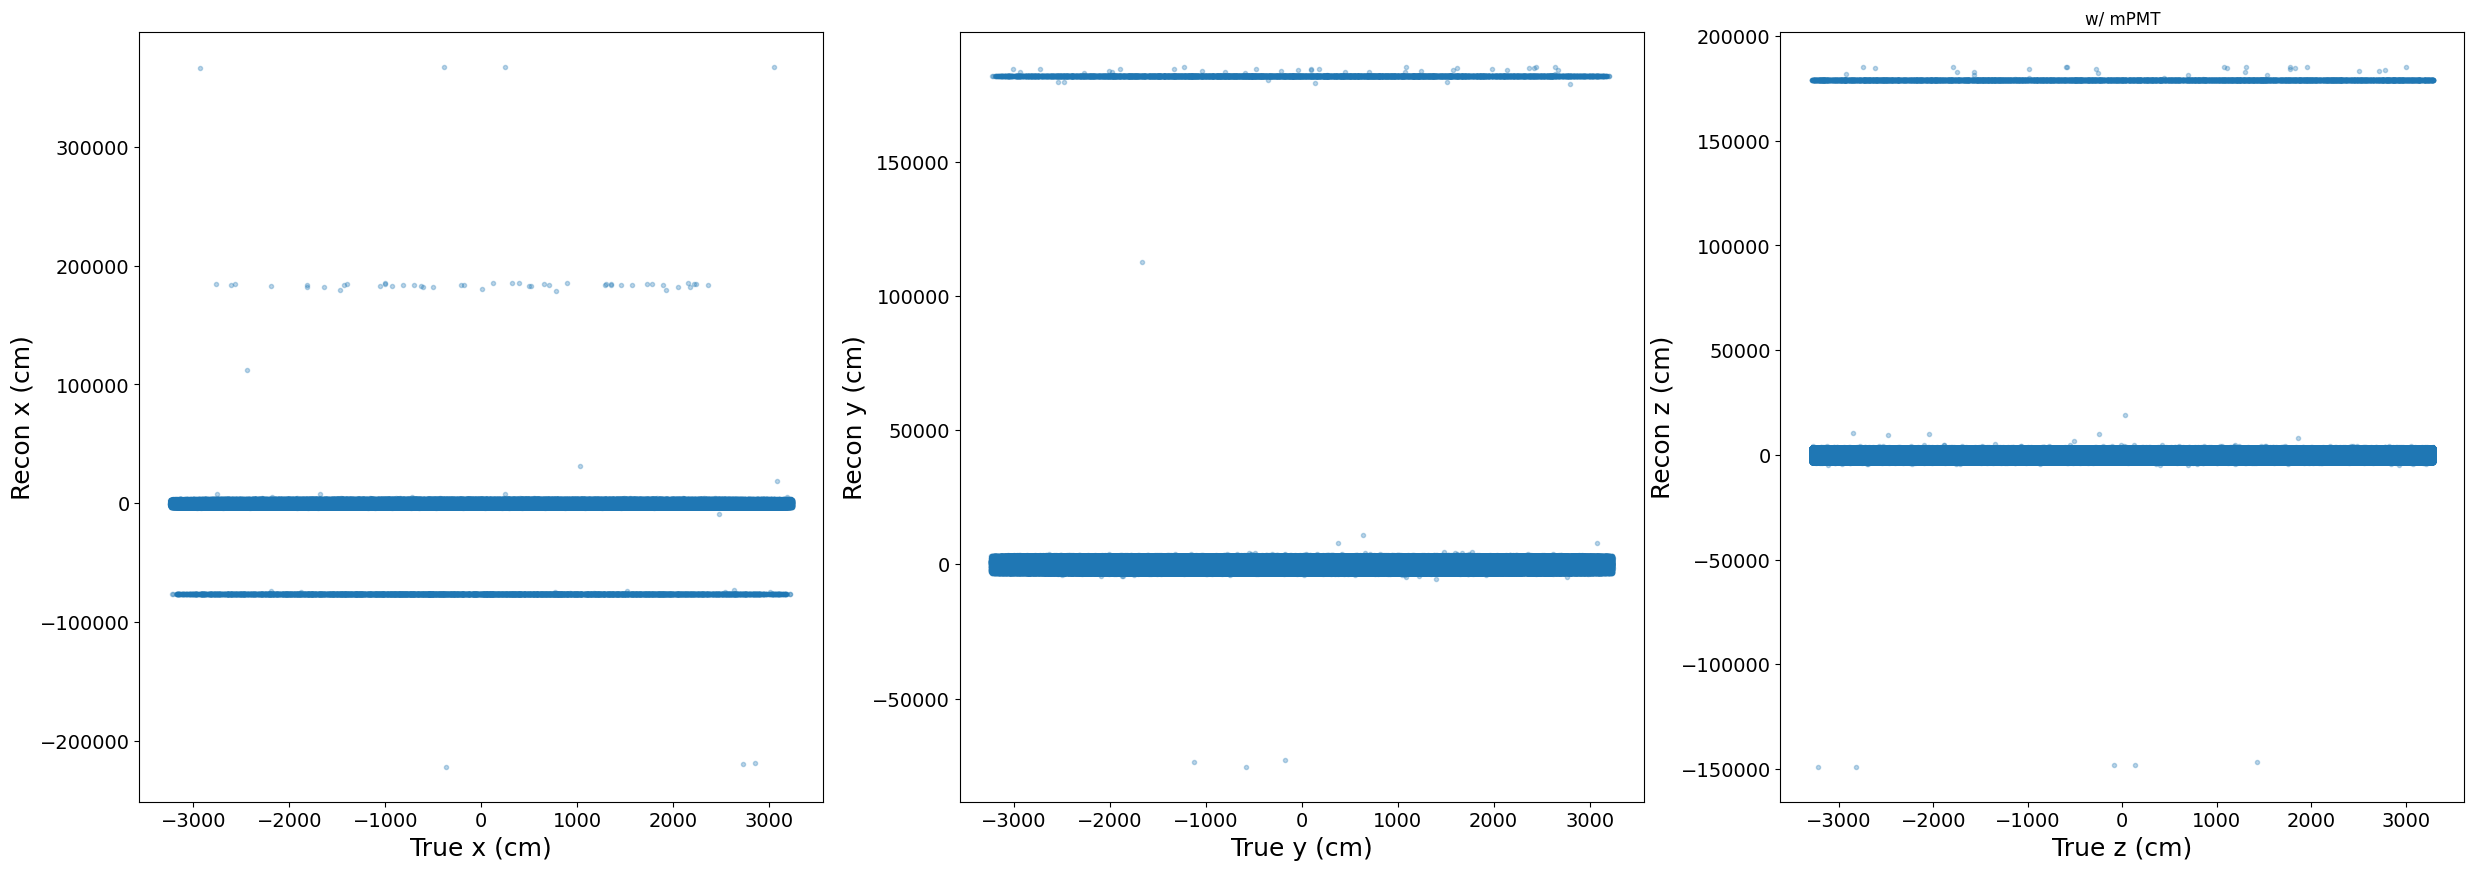

In [20]:
xlabels=['x', 'y', 'z']
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
for i in range(3):
#     axs[i].plot(h5_positions[:,i], fq_reco_pos_e[:,i], ".", alpha=0.3)
    axs[i].plot(h5_positions[h5_labels==2][:,i], fq_reco_pos_mu[:,i], ".", alpha=0.3)
    axs[i].set_xlabel(f"True {xlabels[i]} (cm)", fontsize=18)
    axs[i].set_ylabel(f"Recon {xlabels[i]} (cm)", fontsize=18)

#     axs[i].set_ylim([-3600, 3600])
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    plt.title('w/ mPMT')

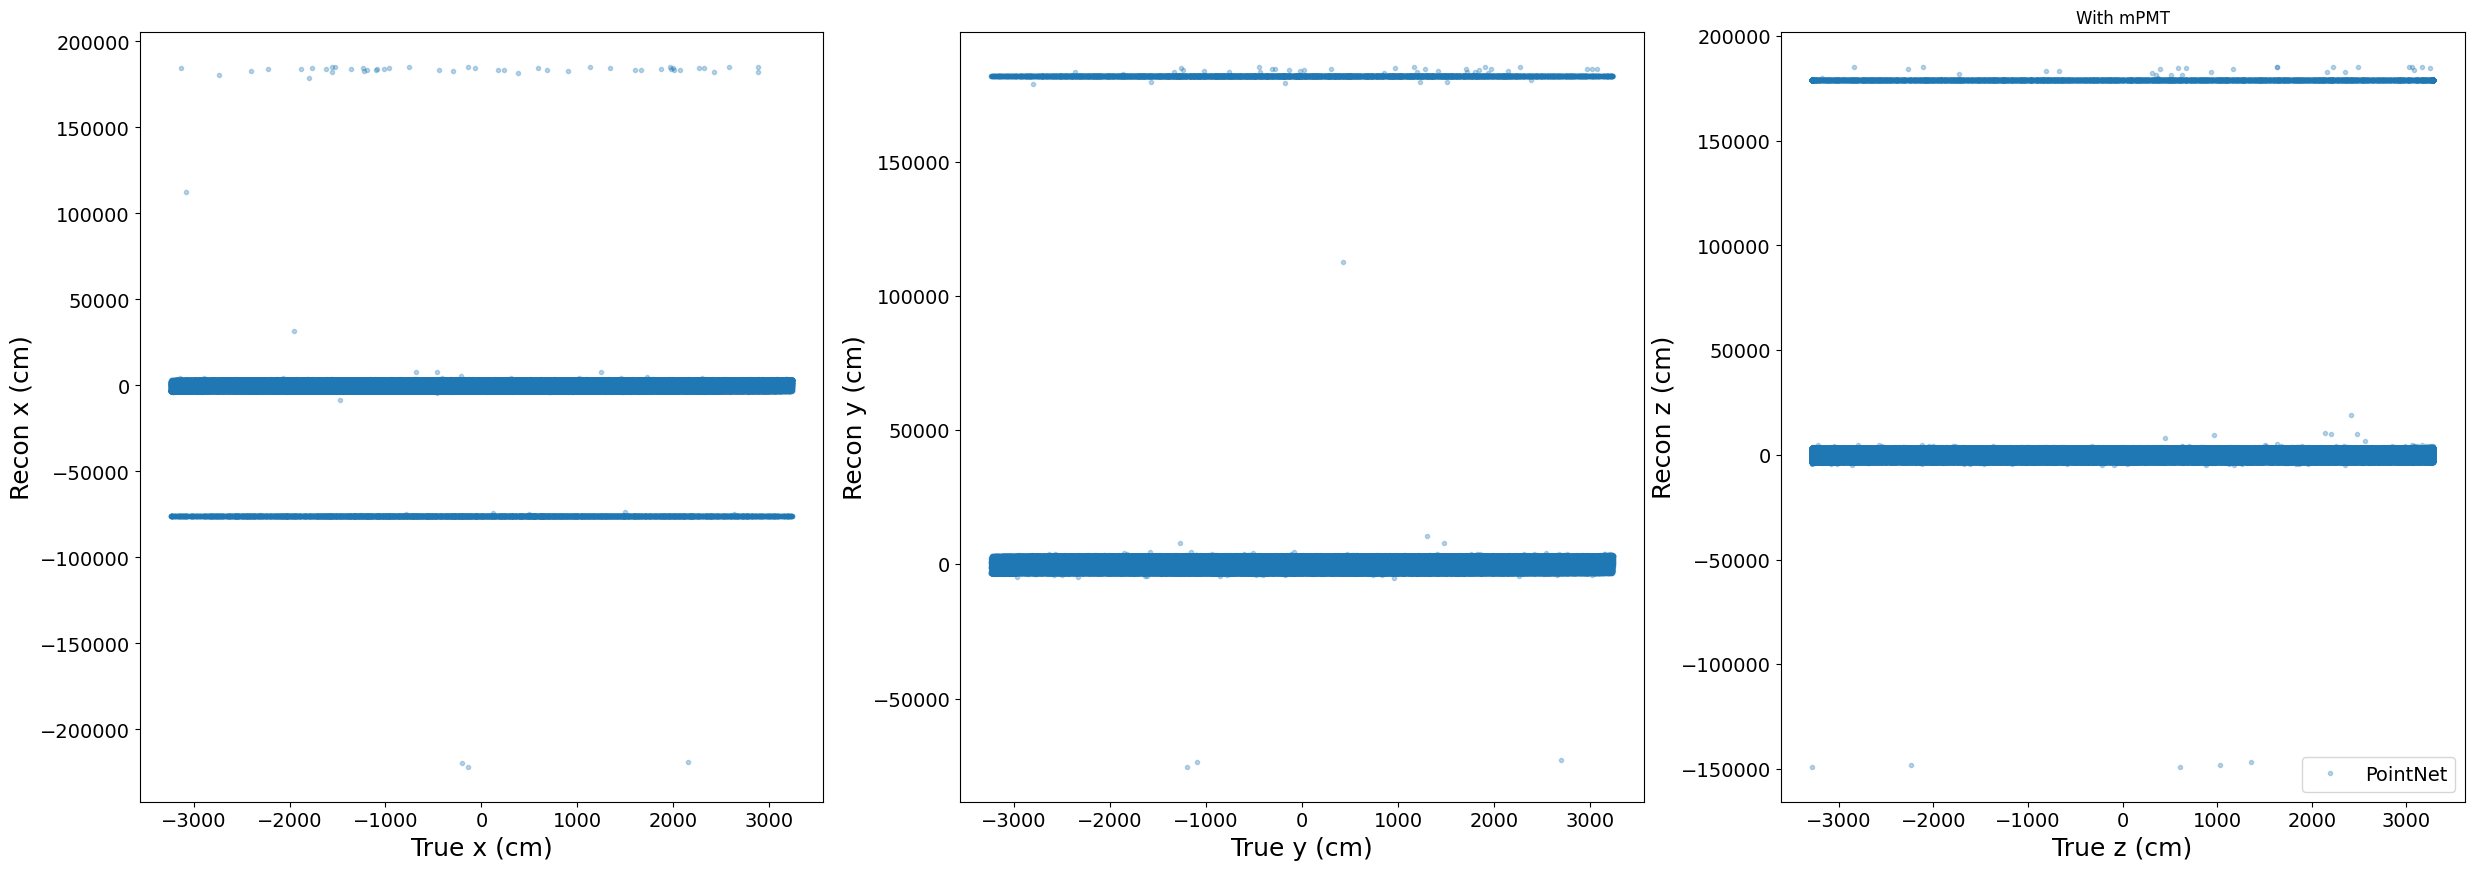

In [24]:
xlabels=['x', 'y', 'z']
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
for i in range(3):
    axs[i].plot(h5_positions[:,i], fq_reco_pos_e[:,i], ".", alpha=0.3, label='PointNet')
    axs[i].set_xlabel(f"True {xlabels[i]} (cm)", fontsize=18)
    axs[i].set_ylabel(f"Recon {xlabels[i]} (cm)", fontsize=18)

#     axs[i].set_ylim([-3600, 3600])
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    plt.title('With mPMT')
    
plt.legend(fontsize=14)

### Position recon

In [40]:
# 3D position difference
x_err = (h5_positions[h5_labels==1][:,0] - fq_reco_pos_e[h5_labels==1][:,0])**2
y_err = (h5_positions[h5_labels==1][:,1] - fq_reco_pos_e[h5_labels==1][:,1])**2
z_err = (h5_positions[h5_labels==1][:,2] - fq_reco_pos_e[h5_labels==1][:,2])**2
error_3d = np.sqrt(x_err + y_err + z_err)

(0.0, 100.0)

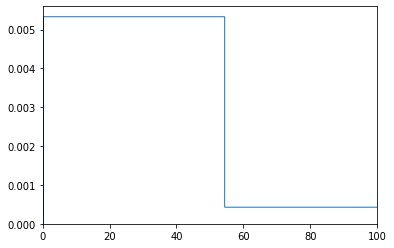

In [42]:
plt.hist(error_3d, histtype='step', bins=5000, density=True)
plt.xlim([0,100])

Text(0.5, 1.0, 'e')

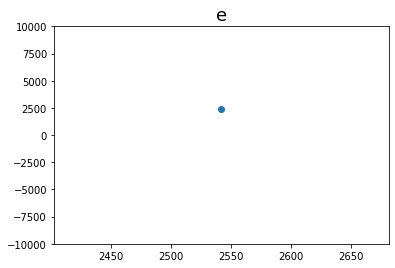

In [38]:
# check gamma seem to be matched right, should be roughly diagonal fitqun momentum vs true energy
# fig, axs = plt.subplots(1,2,figsize=(20,8))
diff = h5_positions[h5_labels==1][:,0] - fq_reco_pos_e[h5_labels==1][:,0]
# plt.hist(diff)#, 'o')
plt.plot(h5_positions[h5_labels==1][:,0][400001:400002], fq_reco_pos_e[h5_labels==1][:,0][400001:400002], 'o')
# p = axs[1].hist2d(h5_positions[h5_labels==1][:,0], fq_reco_pos_e[h5_labels==1][:,0], bins=100, range=[[-3400,3400],[-3400,3400]])
# plt.xlabel("True x Position (cm)", fontsize=18)
# plt.ylabel("FiTQun Recon x Position (cm)", fontsize=18)
# plt.xticks(fontsize=18)  # changing x-axis lable size
# plt.yticks(fontsize=18)
plt.ylim([-10000,10000])
plt.title("e", fontsize=18)

In [27]:
error_E = h5_energies[h5_labels==1] - fq_reco_mom_e[h5_labels==1]
print(error_E)

[ 28.566956 277.3051    38.736084 ...  35.635254   5.409607 -97.31085 ]


### Recon vs real gamma mom

In [ ]:
# check gamma seem to be matched right, should be roughly diagonal fitqun momentum vs true energy
fig, ax = plt.subplots(1,1,figsize=(12,8))
p = ax.hist2d(h5_energies[h5_labels==0], fq_reco_mom_e[h5_labels==0], bins=100, range=[[0,1000],[0,1200]])
plt.xlabel("True Energy (MeV)", fontsize=18)
plt.ylabel("FiTQun Recon Momentum (MeV)", fontsize=18)
plt.xticks(fontsize=18)  # changing x-axis lable size
plt.yticks(fontsize=18)
plt.title("$\gamma$", fontsize=18)

Text(0.5, 1.0, 'E-')

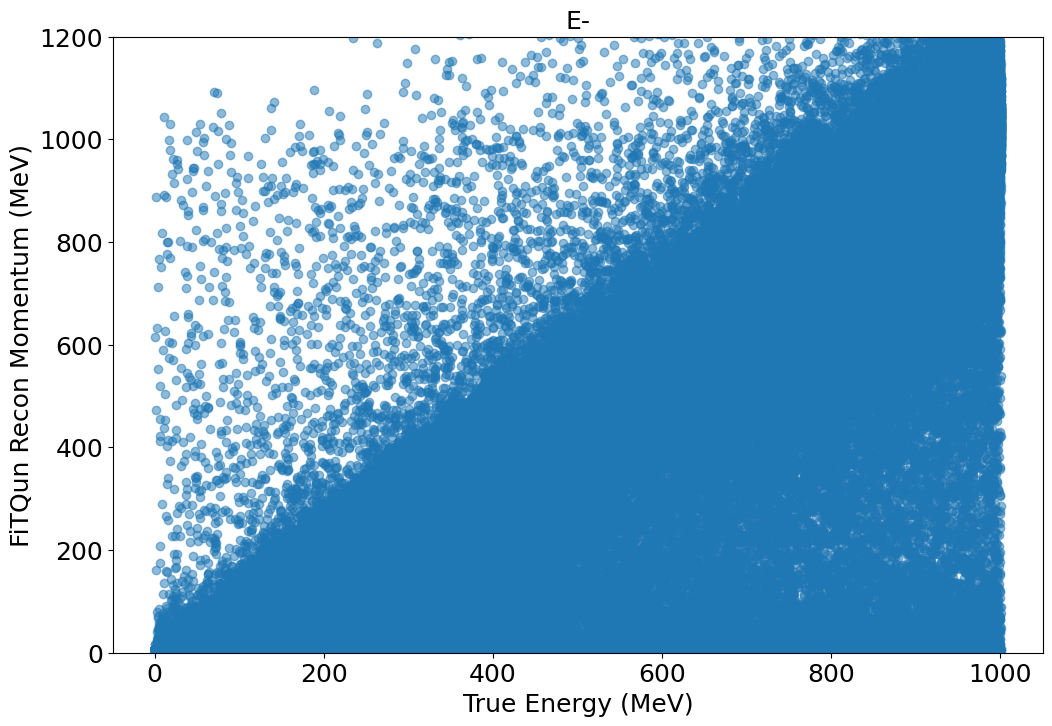

In [25]:
# check e- seem to be matched right, should be roughly diagonal fitqun momentum vs true energy
fig, ax = plt.subplots(1,1,figsize=(12,8))
# p = ax.hist2d(h5_energies[h5_labels==1], fq_reco_mom_e[h5_labels==1], bins=100, range=[[0,1000],[0,1200]])
plt.plot(h5_energies[h5_labels==1], fq_reco_mom_e[h5_labels==1], 'o', alpha=0.5)
plt.xlabel("True Energy (MeV)", fontsize=18)
plt.ylabel("FiTQun Recon Momentum (MeV)", fontsize=18)
plt.xticks(fontsize=18)  # changing x-axis lable size
plt.yticks(fontsize=18)
plt.ylim([0,1200])
plt.title("E-", fontsize=18)

In [ ]:
# check muons
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.hist(h5_energies[h5_labels==2], fq_reco_mom_mu[h5_labels==2], bins=100, range=[[0,1000],[0,1200]])
plt.xlabel("True Energy (MeV)", fontsize=18)
plt.ylabel("FiTQun Recon Momentum (MeV)", fontsize=18)
plt.xticks(fontsize=18)  # changing x-axis lable size
plt.yticks(fontsize=18)
plt.title("Mu-", fontsize=18)

Text(0.5, 1.0, 'Pi0')

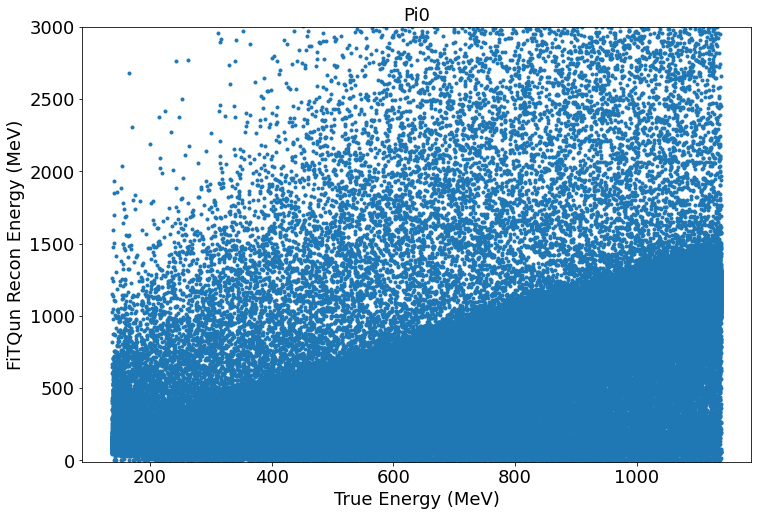

In [39]:
# check pi0
fig, ax = plt.subplots(1,1,figsize=(12,8))
E_pi0 = np.sqrt(fq_reco_mom_pi0[h5_labels==3]**2 + fq_pi0mass[h5_labels==3]**2)
# p = ax.hist2d(h5_energies[h5_labels==3], E_pi0, bins=100, range=[[0,1000],[0,1200]])
ax.plot(h5_energies[h5_labels==3], E_pi0, '.')
plt.xlabel("True Energy (MeV)", fontsize=18)
plt.ylabel("FiTQun Recon Energy (MeV)", fontsize=18)
plt.xticks(fontsize=18)  # changing x-axis lable size
plt.yticks(fontsize=18)
plt.ylim([-10,3000])
plt.title("Pi0", fontsize=18)

# Plotting fiTQun and PointNet performance

## Set up plotting style

In [15]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 28}
matplotlib.rc('font', **font)

## Make some cuts to select the events of interest

In [13]:
# need to overwrite the tank_half_height and tank_radius parameters that towall and dwall funcs takes in
# The length unit is mm and the the lengths are the dimentions of the ID, so HK ID tank is 32.4m (?) in radius
# and 65.8 m (?) in height. Note the half height is 32.9 m.
towall = ev.towall(h5_positions, h5_angles, tank_half_height=3287, tank_radius=3240, tank_axis=2)
dwall = ev.dwall(h5_positions, tank_half_height=3287, tank_radius=3240, tank_axis=2)
momentum = ev.momentum(h5_energies, h5_labels)

In [14]:
towall_cut = towall > 0.63*np.log(momentum) # only for electrons
dwall_cut = dwall > 0.
reco_cut = (fq_flag_e == 0) & (fq_flag_mu == 0)
od_veto_cut = (h5_vetos == 0)

# select the true electron events that pass the cuts
# gammas = (h5_labels==0) & dwall_cut & reco_cut & od_veto_cut
# select the true electron events that pass the cuts
electrons = (h5_labels==1) & towall_cut & dwall_cut & reco_cut & od_veto_cut
# select the true muon events that pass the cuts
muons = (h5_labels==2) & dwall_cut & reco_cut & od_veto_cut
# select the true pi0 events that pass the cuts
# pi0s = (h5_labels==3)  & dwall_cut & reco_cut & od_veto_cut

In [38]:
h5_labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

# Function for plotting eff vs kinematics

In [25]:
def plot_eff_vs_kin(kinematic_var, fq_e_tp, pn_e_tp, hist_range_low=0, hist_range_high=1000, hist_bin_width=50,
                    title="", x_label="", y_label="Electron Efficiency"):
    """
    Plotting electron efficiency vs true kinematic for given kinematic variable

    Parameters
    ----------
    kinematic_var : array_like
        Array of true momenta for all events, typically of the size (2400000, 1)
    fq_e_tp : array_like
        Array of calculated fiTQun e true positive values, typically of the size (2400000,1)
    pn_e_tp : array_like
        Array of calculated PointNet e true positive values, typically of the size (2400000,1)
    hist_range_low : float, default: 0.
        The lower bound of the histogram plot
    hist_range_high : float, default: 1000.
        The upper bound of the histogram plot
    hist_bin_width : float, default: 50.
        The width of each histogram bin
    title : string, default: empty
        The title of the plot
    x_label : string, default: empty
        The title of the x-axis
    y_label : string, default: "Electron Efficiency"
        The title of the y-axis
    """
    # define the bins for the plot
    plot_bin_low = hist_range_low
    plot_bin_high = hist_range_high
    plot_bin_width = hist_bin_width
    plot_bin_lows = np.arange(plot_bin_low, plot_bin_high, plot_bin_width)
    plot_bin_centres = np.arange(plot_bin_low + plot_bin_width/2, plot_bin_high, plot_bin_width)
    plot_bin_halfwidths = np.full_like(plot_bin_centres, plot_bin_width/2)

    # for each particle, each bin, find the events in that bin
    plot_bin_selections = [ (kinematic_var[electrons] > l) & (kinematic_var[electrons] <= l+plot_bin_width) for l in plot_bin_lows ]

    # for each particle, for each bin, calculate the efficiency rate and the error bar
    # for fiTQun
    fq_eff_binned = np.array([np.mean(fq_e_tp[c]) for c in plot_bin_selections])
    fq_eff_binned_err = np.sqrt(fq_eff_binned*(1-fq_eff_binned)/np.sum(plot_bin_selections, axis=1))
    # for PointNet
    pointnet_eff_binned = np.array([np.mean(pn_e_tp[c]) for c in plot_bin_selections])
    pointnet_eff_binned_err = np.sqrt(pointnet_eff_binned*(1-pointnet_eff_binned)/np.sum(plot_bin_selections, axis=1))

    # plot the results
    fig, ax = plt.subplots(figsize=(12,8))
    ax.errorbar(plot_bin_centres, fq_eff_binned, yerr=fq_eff_binned_err, xerr=plot_bin_halfwidths,
                label='fiTQun', color='C3', fmt='-o')
    ax.errorbar(plot_bin_centres, pointnet_eff_binned, yerr=pointnet_eff_binned_err, xerr=plot_bin_halfwidths,
                label='PointNet', color='C0', fmt='-o')
#     ax.set_title(title)
    ax.set_xlabel(x_label, fontsize=18)
    ax.set_ylabel(y_label, fontsize=18)
    ax.tick_params(which='both', labelsize=14)
    ax.legend(fontsize=14)
    ax.set_ylim(0.5,1.1)
    plt.grid(True)
    fig.tight_layout()
#     plt.savefig(f'plots/e-mu-_classification/{title.replace(" ", "_")}.png')

# electron efficiency for fixed 20% gamma mis-ID

## VS true momentum

### for each 50 MeV bin of reconstructed momentum, calculate the thresholds for fiTQun

In [140]:
# the electron-like discriminator is the negative log-likelihood difference for fiTQun (es are more mu-like...)
eg_nll = fq_e_nll - fq_g_nll

# set up the bins
bin_low = 0
bin_high = 1000
bin_width = 50
bin_lows = np.arange(bin_low, bin_high, bin_width)

# for each particle type, for each bin, make a boolean array to say whether each event belongs in that bin
e_bin_selections = [ (fq_reco_mom_e[electrons] > l) & (fq_reco_mom_e[electrons] <= l+bin_width) for l in bin_lows ]
g_bin_selections = [ (fq_reco_mom_e[gammas] > l) & (fq_reco_mom_e[gammas] <= l+bin_width) for l in bin_lows ]

# for each bin, the threshold that gives 20% mis-ID (80% are below the threshold)
fq_thresholds = [ np.quantile(eg_nll[gammas][c], 0.8) for c in g_bin_selections ]

# for each particle type, for each bin, make a boolean array to say whether each event is below the threshold
# start by filling it full of false
fq_electron_truepositives = np.zeros_like(eg_nll[electrons]).astype(bool)
fq_gamma_falsepositives = np.zeros_like(eg_nll[gammas]).astype(bool)
# then loop over the bins and set to true for the events in those bins that are over the threshold
for t, c in zip(fq_thresholds, e_bin_selections):
    fq_electron_truepositives[c] = eg_nll[electrons][c] > t
for t, c in zip(fq_thresholds, g_bin_selections):
    fq_gamma_falsepositives[c] = eg_nll[gammas][c] > t

### calculate the thresholds for PointNet

In [139]:
# the electron-like discriminator is 1-[muon softmax] 
elike_softmax = (1-softmaxes[:,0])
# elike_softmax = (softmaxes[:,1])/(softmaxes[:,0] + softmaxes[:,1])

# print(len(elike_softmax), len(mu_bin_selections))

# for each bin, the threshold that gives 0.5% mis-ID (99.5% are below the threshold)
pointnet_thresholds = [np.quantile(elike_softmax[gammas][c], 0.8) for c in g_bin_selections]

# resnet_thresholds = [np.quantile(elike_softmax[muons][c], 0.995) for c in mu_bin_selections]

# for each particle type, for each bin, make a, boolean array to say whether each event is below the threshold
# start by filling it full of false
pointnet_electron_truepositives = np.zeros_like(elike_softmax[electrons]).astype(bool)
pointnet_gamma_falsepositives = np.zeros_like(elike_softmax[gammas]).astype(bool)
# then loop over the bins and set to true for the events in those bins that are over the threshold
for t, c in zip(pointnet_thresholds, e_bin_selections):
    pointnet_electron_truepositives[c] = elike_softmax[electrons][c] > t
for t, c in zip(pointnet_thresholds, g_bin_selections):
    pointnet_gamma_falsepositives[c] = elike_softmax[gammas][c] > t

### Plot against true momentum

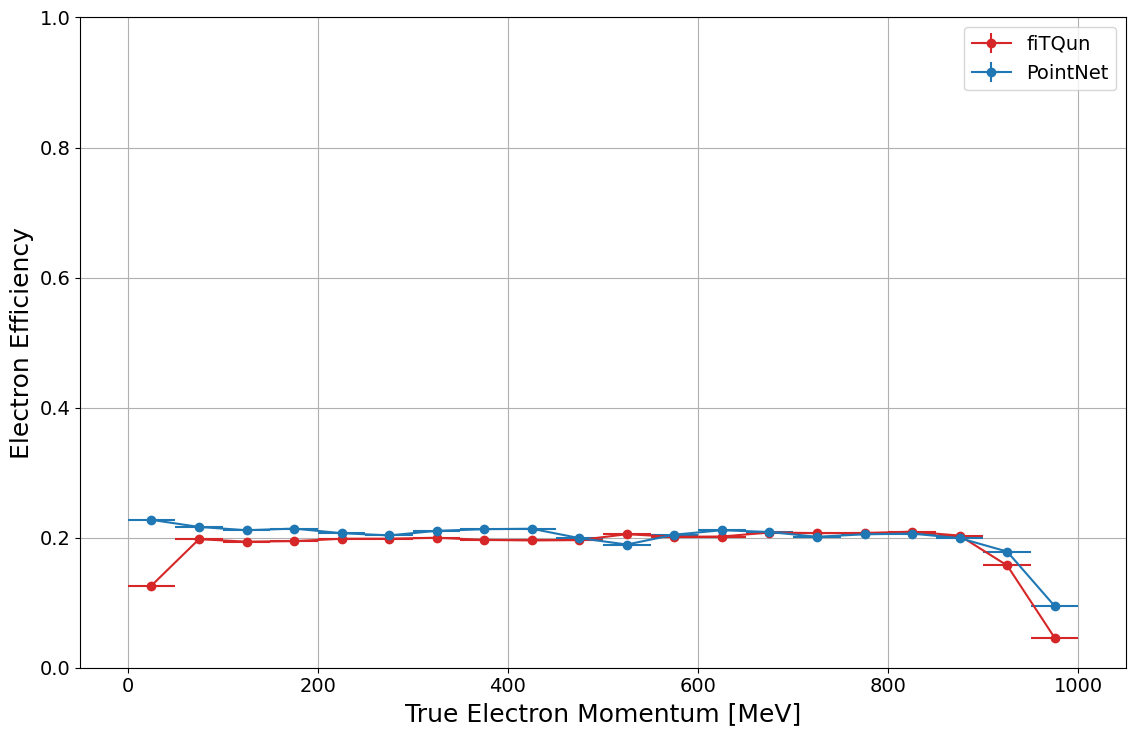

In [141]:
plot_eff_vs_kin(momentum, fq_electron_truepositives, pointnet_electron_truepositives, 
                hist_range_low=0, hist_range_high=1000, hist_bin_width=50,
                title="e-g efficienty vs momentum", 
                x_label="True Electron Momentum [MeV]", y_label="Electron Efficiency")

### Plot against towall variable

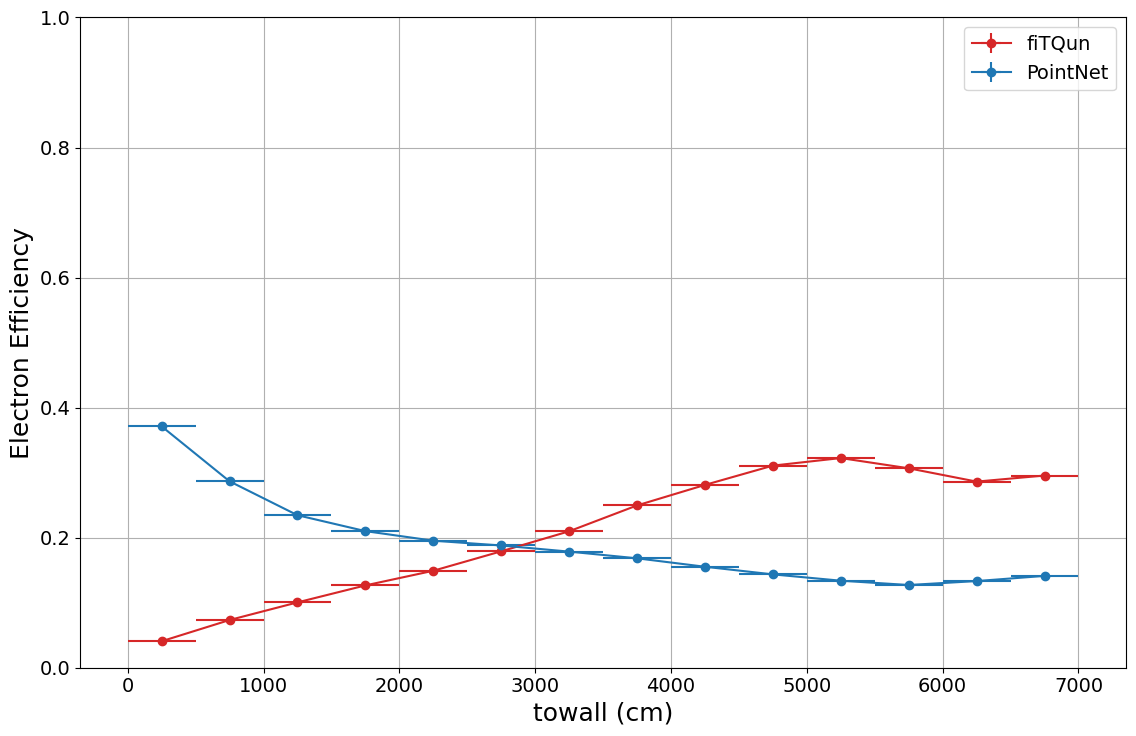

In [143]:
plot_eff_vs_kin(towall, fq_electron_truepositives, pointnet_electron_truepositives, 
                hist_range_low=0, hist_range_high=7000, hist_bin_width=500,
                title="e-g efficienty vs towall 0-7000", 
                x_label="towall (cm)",
                y_label="Electron Efficiency")

### Plot against dwall variable

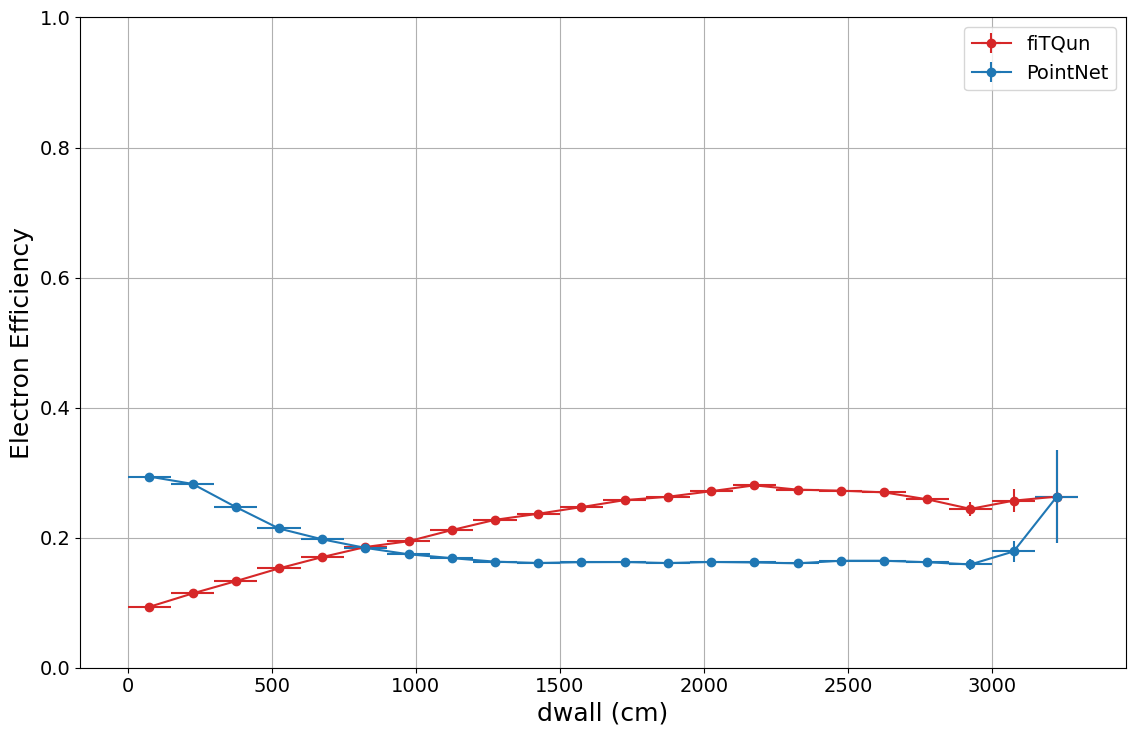

In [144]:
plot_eff_vs_kin(dwall, fq_electron_truepositives, pointnet_electron_truepositives, 
                hist_range_low=0, hist_range_high=3240, hist_bin_width=150,
                title="e-g efficienty vs dwall", 
                x_label="dwall (cm)",
                y_label="Electron Efficiency")

### Plot against zenith angle

In [145]:
cos_zenith = np.cos(h5_angles[:,0])

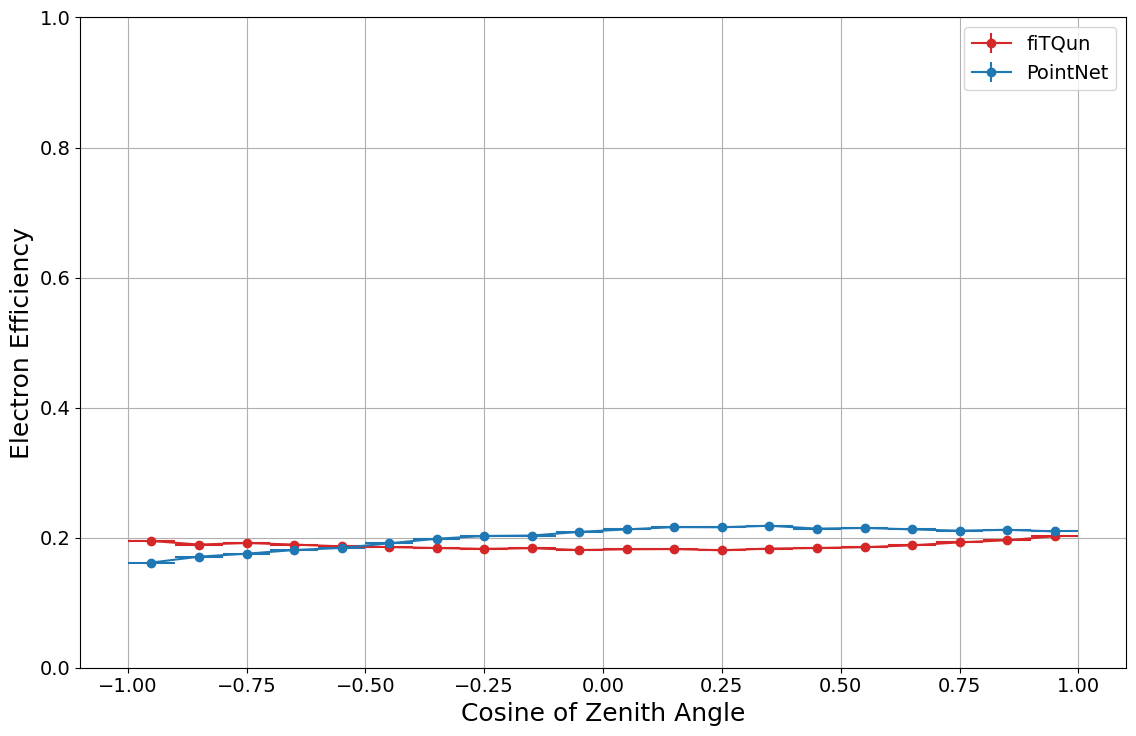

In [146]:
plot_eff_vs_kin(cos_zenith, fq_electron_truepositives, pointnet_electron_truepositives, 
                hist_range_low=-1, hist_range_high=1, hist_bin_width=0.1,
                title="e-g efficienty vs cos of zenith", x_label="Cosine of Zenith Angle",
                y_label="Electron Efficiency")

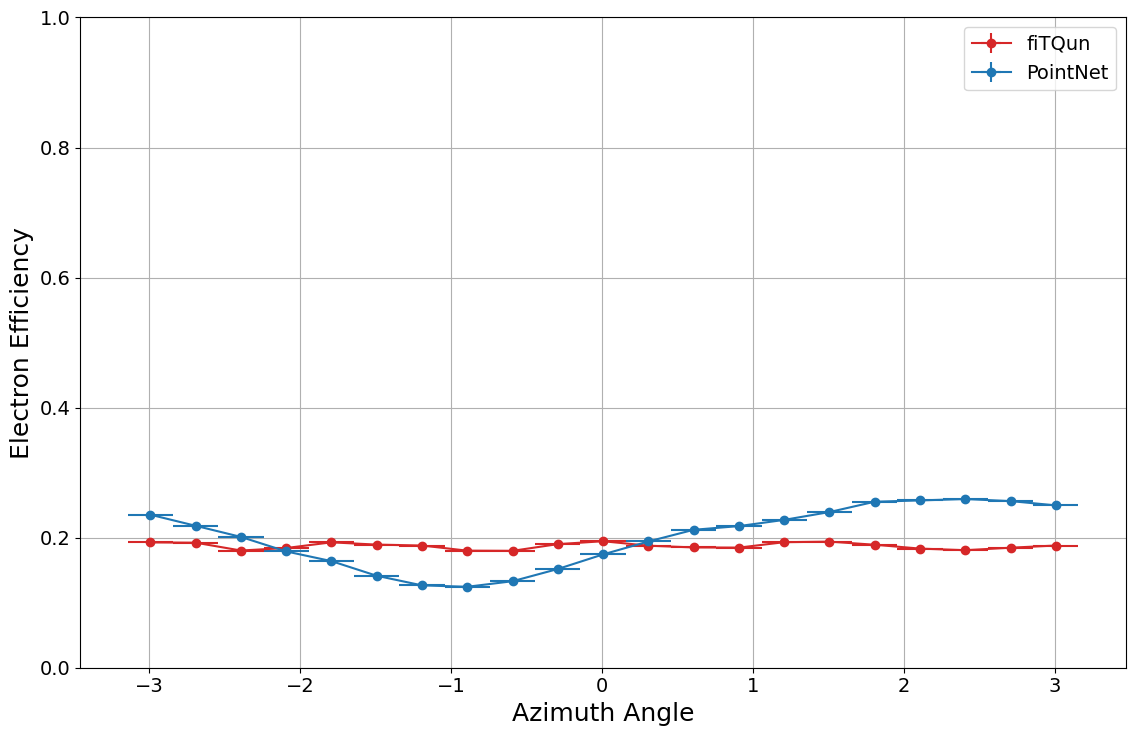

In [148]:
plot_eff_vs_kin(h5_angles[:,1], fq_electron_truepositives, pointnet_electron_truepositives, 
                hist_range_low=-np.pi, hist_range_high=np.pi, hist_bin_width=0.3,
                title="e-g efficienty vs azimuth", x_label="Azimuth Angle",
                y_label="Electron Efficiency")

# electron efficiency for fixed 0.5% muon mis-ID

### for each 50 MeV bin of reconstructed momentum, calculate the thresholds for fiTQun

In [27]:
# the electron-like discriminator is the negative log-likelihood difference
emu_nll = fq_mu_nll - fq_e_nll

# set up the bins
bin_low = 0
bin_high = 1000
bin_width = 50
bin_lows = np.arange(bin_low, bin_high, bin_width)

# for each particle type, for each bin, make a boolean array to say whether each event belongs in that bin
e_bin_selections = [
    (fq_reco_mom_e[electrons] > l) & (fq_reco_mom_e[electrons] <= l+bin_width)
    for l in bin_lows
]
mu_bin_selections = [
    (fq_reco_mom_e[muons] > l) & (fq_reco_mom_e[muons] <= l+bin_width)
    for l in bin_lows
]

# for each bin, the threshold that gives 0.5% mis-ID (99.5% are below the threshold)
# fq_thresholds = [np.quantile(emu_nll[electrons][c], 0.005) for c in e_bin_selections]
fq_thresholds = [np.quantile(emu_nll[muons][c], 0.995) for c in mu_bin_selections]

# for each particle type, for each bin, make a, boolean array to say whether each event is below the threshold
# start by filling it full of false
fq_electron_truepositives = np.zeros_like(emu_nll[electrons]).astype(bool)
fq_muon_falsepositives = np.zeros_like(emu_nll[muons]).astype(bool)
# then loop over the bins and set to true for the events in those bins that are over the threshold
for t, c in zip(fq_thresholds, e_bin_selections):
    fq_electron_truepositives[c] = emu_nll[electrons][c] > t
for t, c in zip(fq_thresholds, mu_bin_selections):
    fq_muon_falsepositives[c] = emu_nll[muons][c] > t

### calculate the thresholds for PointNet

In [28]:
# the electron-like discriminator is 1-[muon softmax] 
elike_softmax = (1-softmaxes[:,2])

# for each bin, the threshold that gives 0.5% mis-ID (99.5% are below the threshold)
# pointnet_thresholds = [np.quantile(elike_softmax[electrons][c], 0.005) for c in e_bin_selections]
pointnet_thresholds = [np.quantile(elike_softmax[muons][c], 0.995) for c in mu_bin_selections]

# for each particle type, for each bin, make a, boolean array to say whether each event is below the threshold
# start by filling it full of false
pointnet_electron_truepositives = np.zeros_like(elike_softmax[electrons]).astype(bool)
pointnet_muon_falsepositives = np.zeros_like(elike_softmax[muons]).astype(bool)
# then loop over the bins and set to true for the events in those bins that are over the threshold
for t, c in zip(pointnet_thresholds, e_bin_selections):
    pointnet_electron_truepositives[c] = elike_softmax[electrons][c] > t
for t, c in zip(pointnet_thresholds, mu_bin_selections):
    pointnet_muon_falsepositives[c] = elike_softmax[muons][c] > t

### Plot against true momentum

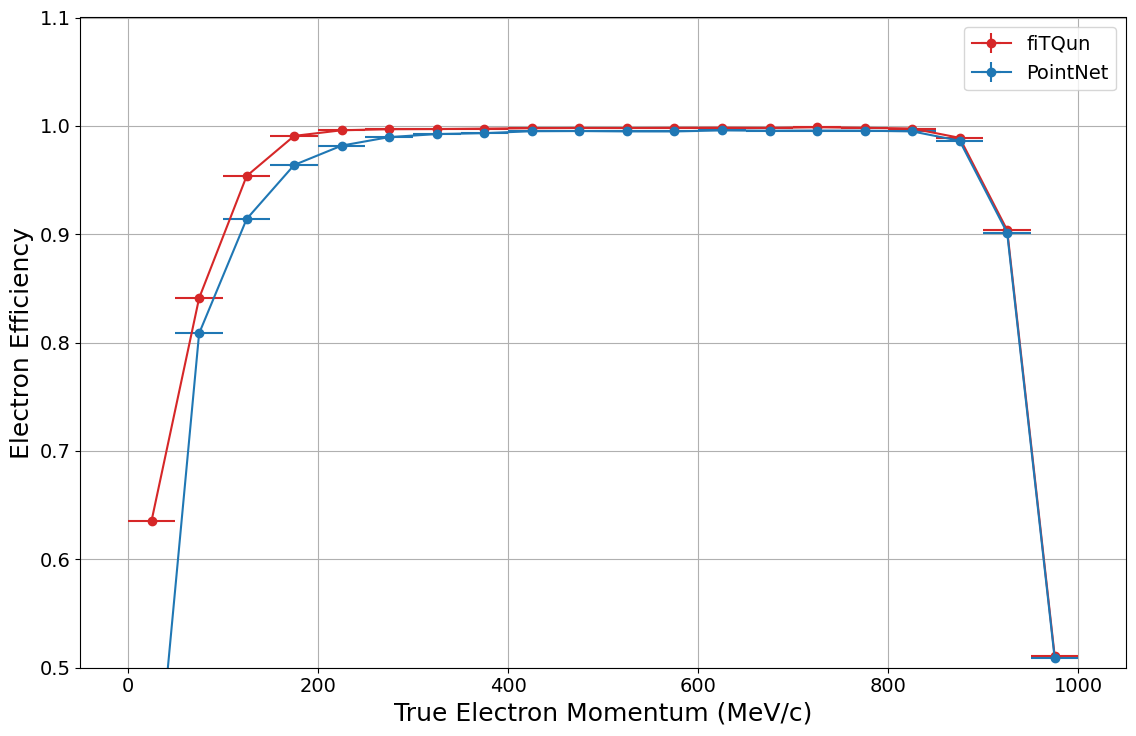

In [29]:
plot_eff_vs_kin(momentum, fq_electron_truepositives, pointnet_electron_truepositives, 
                hist_range_low=0, hist_range_high=1000, hist_bin_width=50, title="e-mu- efficienty vs momentum", 
                x_label="True Electron Momentum (MeV/c)", y_label="Electron Efficiency")

### Plot against towall variable

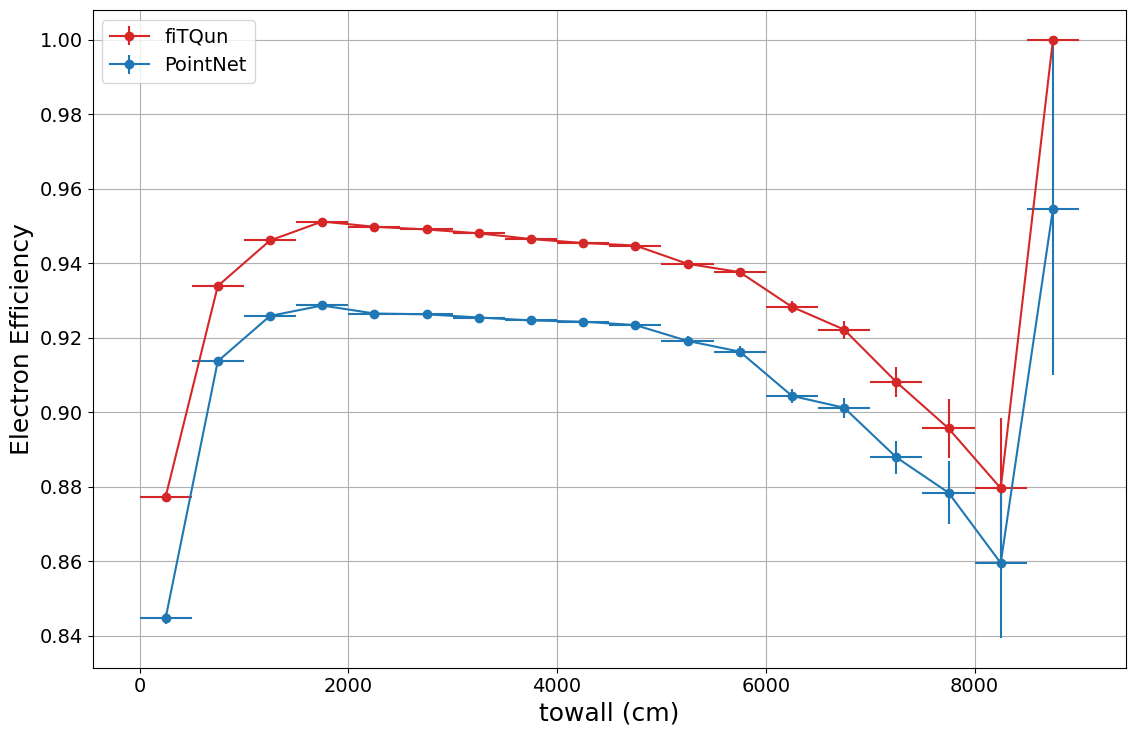

In [65]:
plot_eff_vs_kin(towall, fq_electron_truepositives, pointnet_electron_truepositives, 
                hist_range_low=0, hist_range_high=11000, hist_bin_width=500, 
                title="e-mu- efficienty vs towall 0-11000", 
                #x_label="Distance from Position to Detector Wall, in Particle Direction (towall) (cm)",
                x_label="towall (cm)",
                y_label="Electron Efficiency")

### Plot against dwall variable

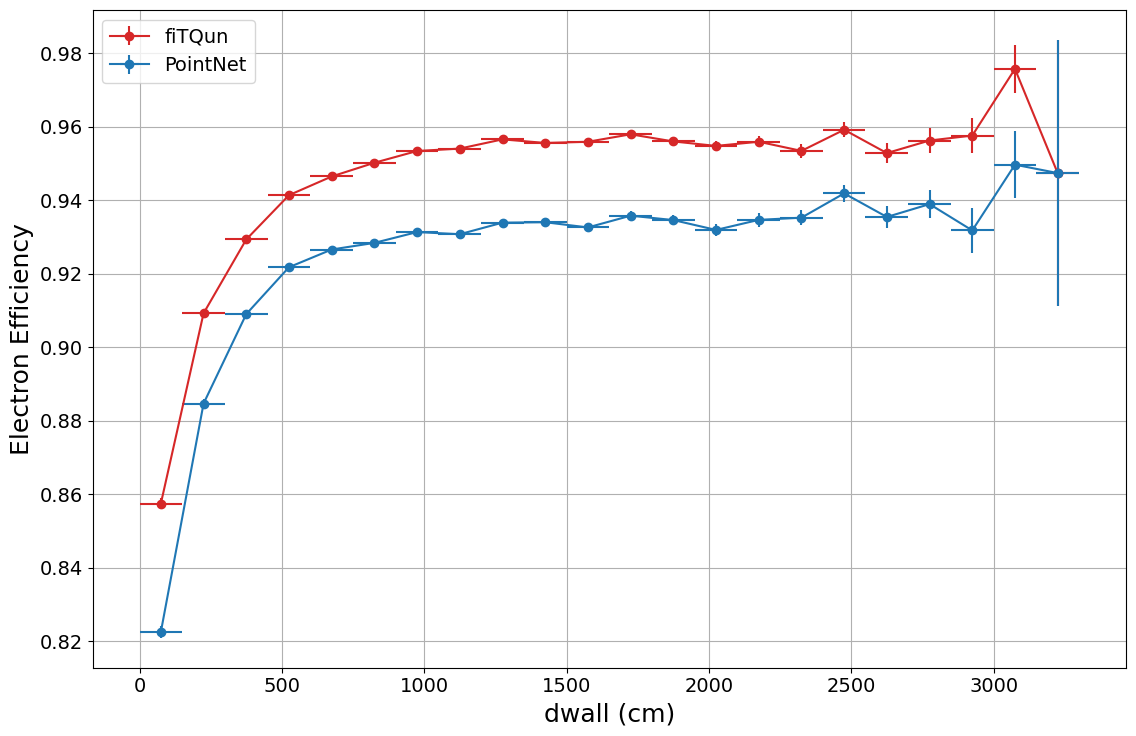

In [66]:
plot_eff_vs_kin(dwall, fq_electron_truepositives, pointnet_electron_truepositives, 
                hist_range_low=0, hist_range_high=3240, hist_bin_width=150, 
                title="e-mu- efficienty vs dwall", 
#                 x_label="Distance from position to nearest detector wall (dwall) [mm]",
                x_label="dwall (cm)",
                y_label="Electron Efficiency")

### Plot against zenith

In [168]:
cos_zenith = np.cos(h5_angles[:,0])

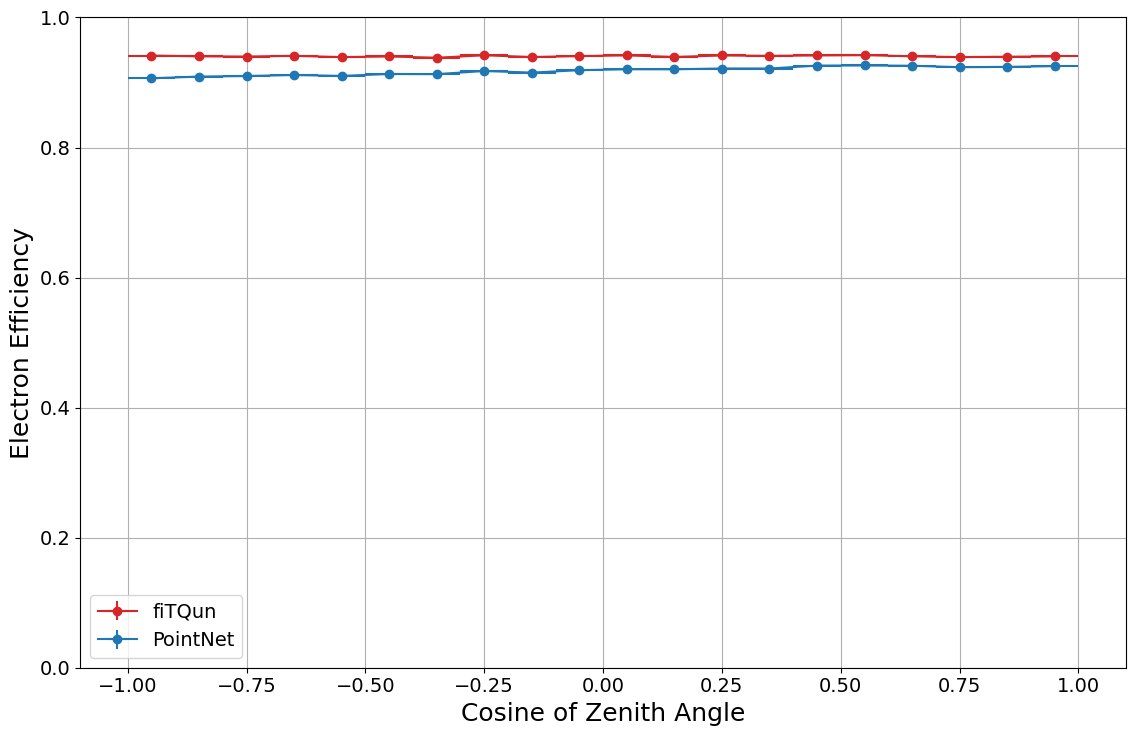

In [172]:
plot_eff_vs_kin(cos_zenith, fq_electron_truepositives, pointnet_electron_truepositives, 
                hist_range_low=-1, hist_range_high=1, hist_bin_width=0.1, 
                title="e-mu- efficienty vs cos of zenith", 
                x_label="Cosine of Zenith Angle",
                y_label="Electron Efficiency")

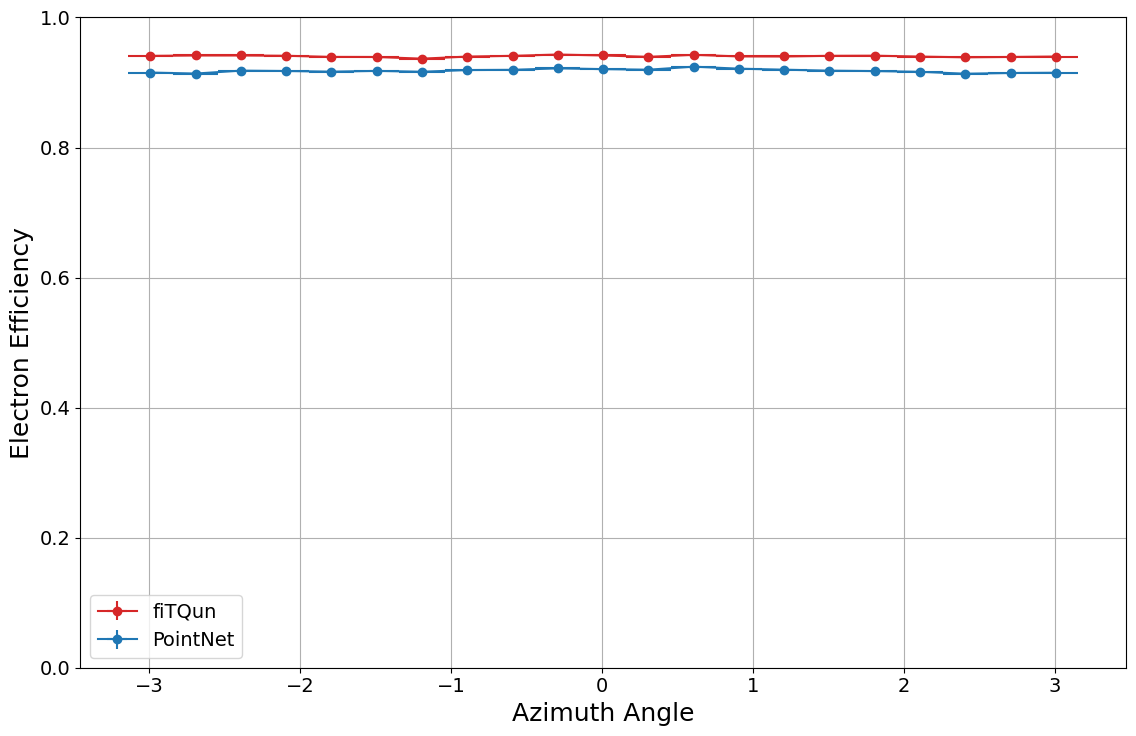

In [173]:
plot_eff_vs_kin(h5_angles[:,1], fq_electron_truepositives, pointnet_electron_truepositives, 
                hist_range_low=-np.pi, hist_range_high=np.pi, hist_bin_width=0.3, 
                title="e-mu- efficienty vs azimuth", 
                x_label="Azimuth Angle",
                y_label="Electron Efficiency")

# electron efficiency for fixed 10% pi0 mis-ID

### for each 50 MeV bin of reconstructed momentum, calculate the thresholds for fiTQun

In [91]:
# the electron-like discriminator is the negative log-likelihood difference
epi0_nll = fq_pi0_nll - fq_e_nll

# set up the bins
bin_low = 0
bin_high = 1000
bin_width = 50
bin_lows = np.arange(bin_low, bin_high, bin_width)

# for each particle type, for each bin, make a boolean array to say whether each event belongs in that bin
e_bin_selections = [
    (fq_reco_mom_e[electrons] > l) & (fq_reco_mom_e[electrons] <= l+bin_width)
    for l in bin_lows
]
pi0_bin_selections = [
    (fq_reco_mom_e[pi0s] > l) & (fq_reco_mom_e[pi0s] <= l+bin_width)
    for l in bin_lows
]

# for each bin, the threshold that gives 0.5% mis-ID (99.5% are below the threshold)
fq_thresholds = [np.quantile(epi0_nll[pi0s][c], 0.1) for c in pi0_bin_selections]

# for each particle type, for each bin, make a, boolean array to say whether each event is below the threshold
# start by filling it full of false
fq_electron_truepositives = np.zeros_like(epi0_nll[electrons]).astype(bool)
fq_pi0_falsepositives = np.zeros_like(epi0_nll[pi0s]).astype(bool)
# then loop over the bins and set to true for the events in those bins that are over the threshold
for t, c in zip(fq_thresholds, e_bin_selections):
    fq_electron_truepositives[c] = epi0_nll[electrons][c] > t
for t, c in zip(fq_thresholds, pi0_bin_selections):
    fq_pi0_falsepositives[c] = epi0_nll[pi0s][c] > t

### calculate the thresholds for PointNet

In [89]:
# the electron-like discriminator is 1-[pi0 softmax] 
elike_softmax = ( 1 - softmaxes[:,3])

# print(len(elike_softmax), len(mu_bin_selections))

# for each bin, the threshold that gives 0.5% mis-ID (99.5% are below the threshold)
# pointnet_thresholds = [np.quantile(elike_softmax[electrons][c], 0.005) for c in e_bin_selections]

pointnet_thresholds = [np.quantile(elike_softmax[pi0s][c], 0.1) for c in pi0_bin_selections]

# for each particle type, for each bin, make a, boolean array to say whether each event is below the threshold
# start by filling it full of false
pointnet_electron_truepositives = np.zeros_like(elike_softmax[electrons]).astype(bool)
pointnet_pi0s_falsepositives = np.zeros_like(elike_softmax[pi0s]).astype(bool)
# then loop over the bins and set to true for the events in those bins that are over the threshold
for t, c in zip(pointnet_thresholds, e_bin_selections):
    pointnet_electron_truepositives[c] = elike_softmax[electrons][c] > t
for t, c in zip(pointnet_thresholds, pi0_bin_selections):
    pointnet_pi0s_falsepositives[c] = elike_softmax[pi0s][c] > t

### Plot against true momentum

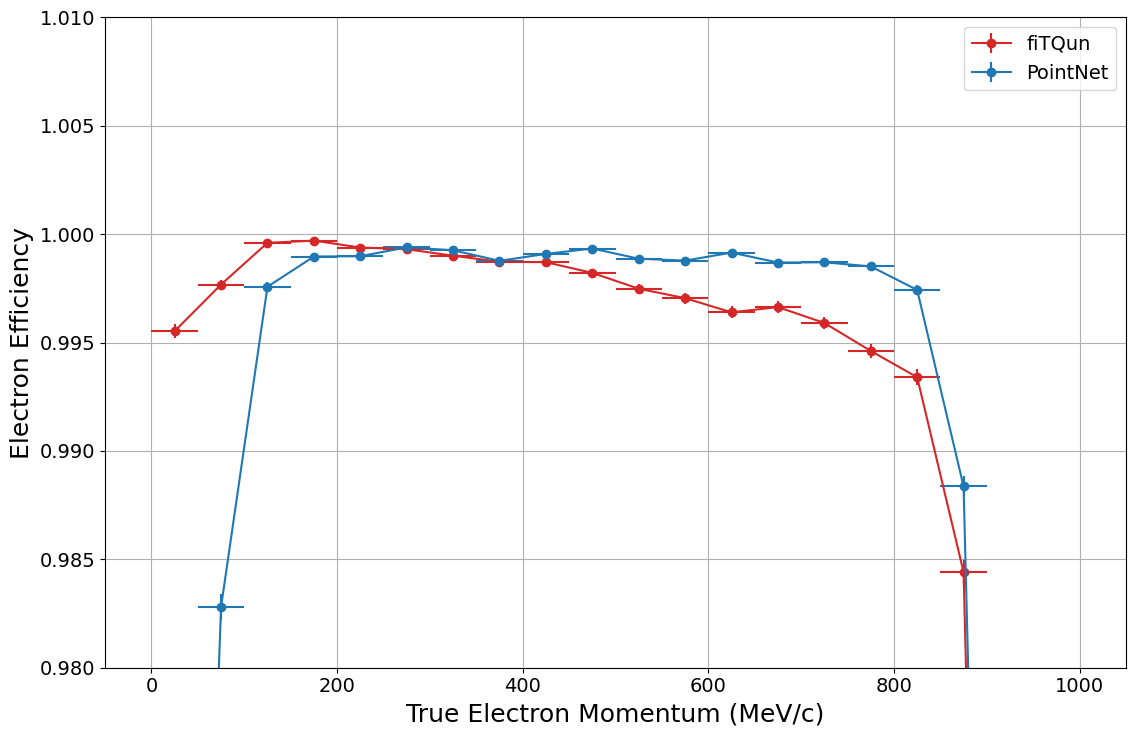

In [101]:
plot_eff_vs_kin(kinematic_var=momentum, fq_e_tp=fq_electron_truepositives, 
                pn_e_tp=pointnet_electron_truepositives, 
                title="e-pi0 efficienty vs momentum y 09-105", 
                x_label="True Electron Momentum (MeV/c)", y_label="Electron Efficiency")

### Plot against towall

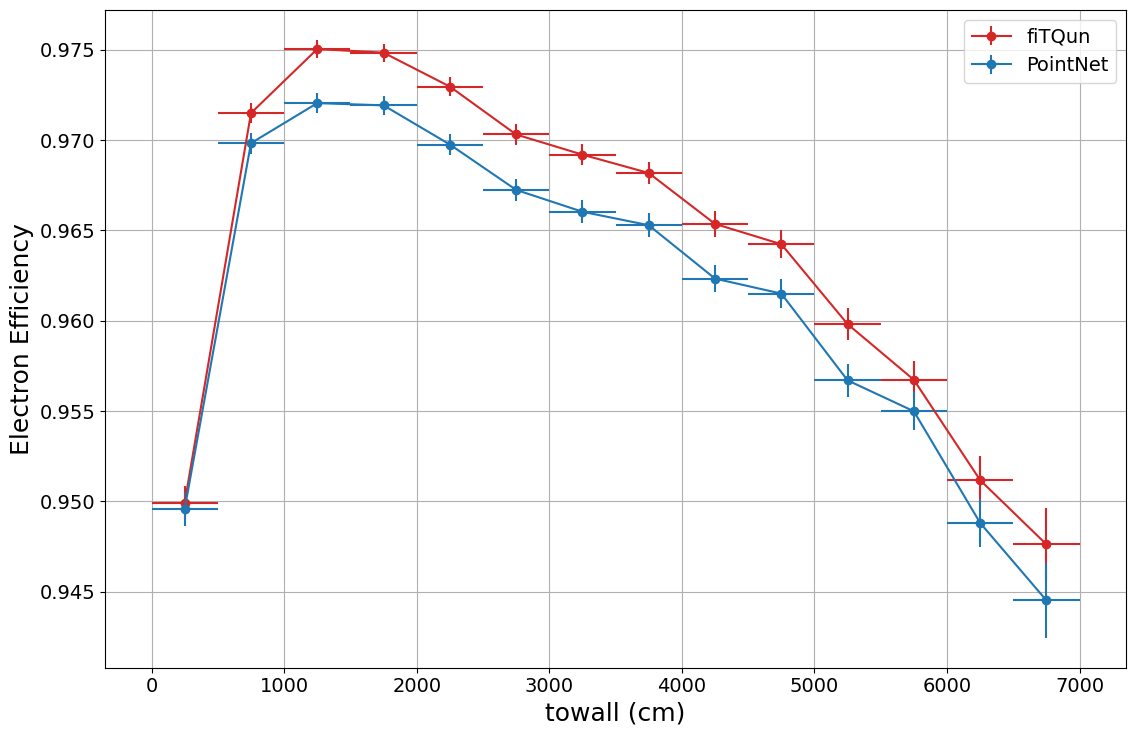

In [107]:
plot_eff_vs_kin(towall, fq_electron_truepositives, pointnet_electron_truepositives, 
                hist_range_low=0, hist_range_high=7000, hist_bin_width=500, 
                title="e-pi0 efficienty vs towall 0-7000", 
                x_label="towall (cm)",
                y_label="Electron Efficiency")

### Plot against dwall

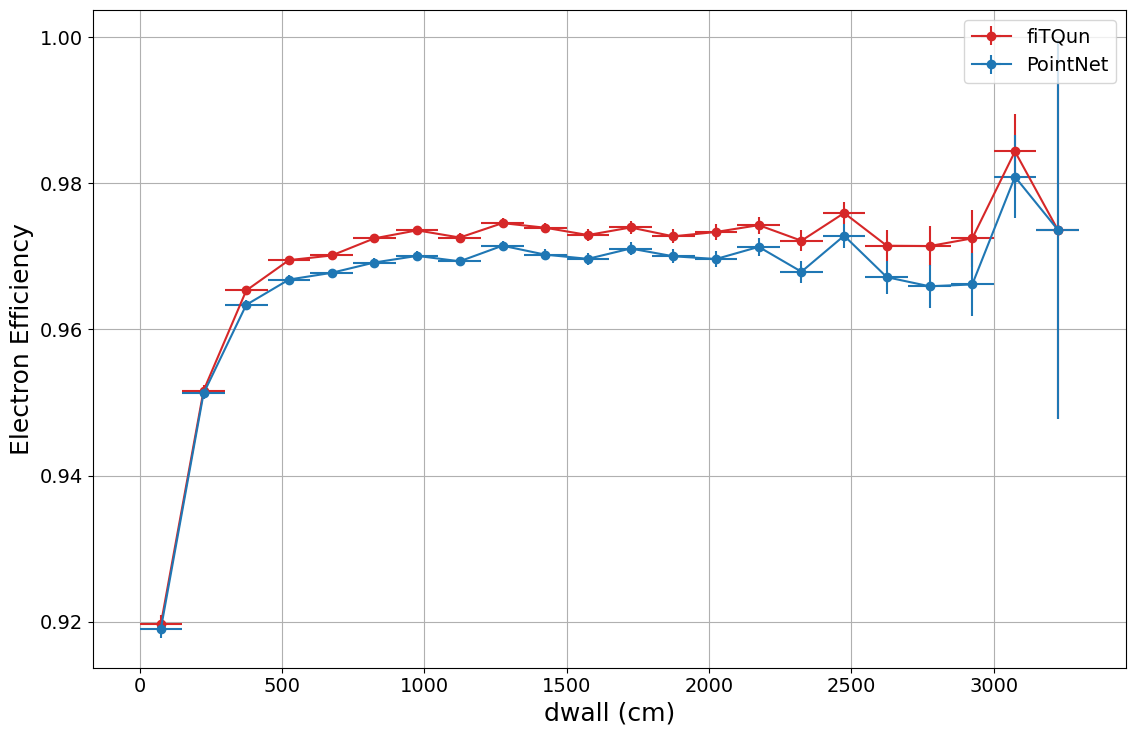

In [108]:
plot_eff_vs_kin(dwall, fq_electron_truepositives, pointnet_electron_truepositives, 
                hist_range_low=0, hist_range_high=3240, hist_bin_width=150, 
                title="e-pi0 efficienty vs dwall", 
                x_label="dwall (cm)",
                y_label="Electron Efficiency")

### Plot against cos zenith angle 

In [109]:
cos_zenith = np.cos(h5_angles[:,0])

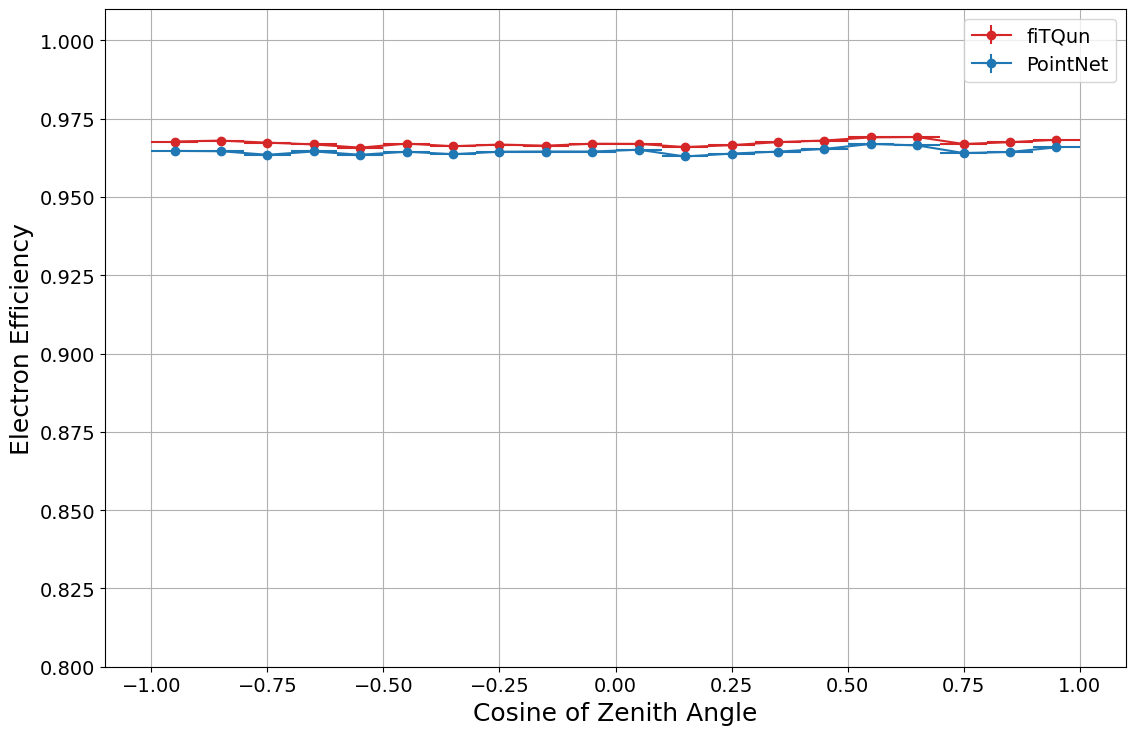

In [114]:
plot_eff_vs_kin(cos_zenith, fq_electron_truepositives, pointnet_electron_truepositives, 
                hist_range_low=-1, hist_range_high=1, hist_bin_width=0.1, 
                title="e-pi0 efficienty vs cos of zenith y 08-101", 
                x_label="Cosine of Zenith Angle",
                y_label="Electron Efficiency")

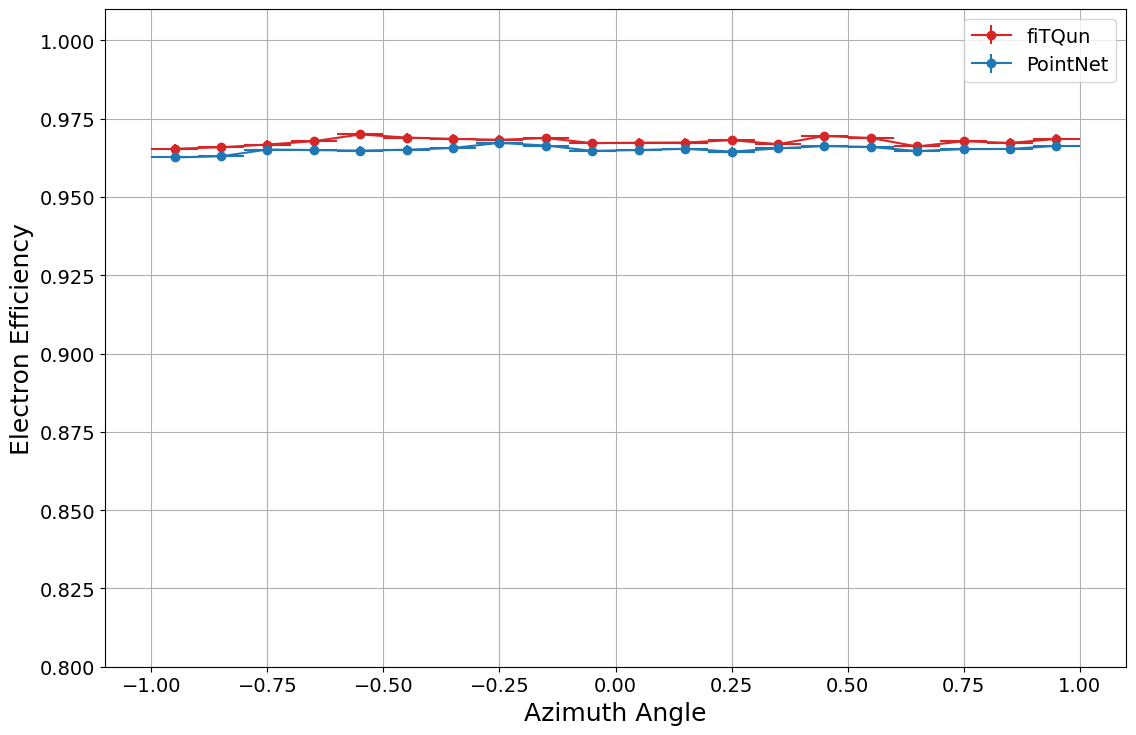

In [115]:
plot_eff_vs_kin(h5_angles[:,1], fq_electron_truepositives, pointnet_electron_truepositives, 
                hist_range_low=-1, hist_range_high=1, hist_bin_width=0.1, 
                title="e-pi0 efficienty vs azimuth", 
                x_label="Azimuth Angle",
                y_label="Electron Efficiency")